In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from scipy.signal import resample
from scipy.signal import correlate

## Check sides (of hand)

In [265]:
pd.read_hdf('//FS2.smpp.local\\RTO\\CIS-PD MUSC\\decoded_forms\\form501.h5')

,SubjectCode,SiteID,VisitNm,Q05,Q06,DataCollected,Q01,Q02,Q03,Q04,Q07
0,1000.0,1313.0,Baseline,XX-XX-2006,XX-XX-2010,Yes,"Masters degree (MA, MS, MENG, MSW, etc)",Retired,Expert (uses independently at least daily),Yes,Right
1,1001.0,1313.0,Baseline,XX-XX-2012,XX-XX-2012,Yes,"Bachelors degree (BA, BS, AB, etc)",Working,Expert (uses independently at least daily),Yes,Left
2,1002.0,1313.0,Baseline,XX-XX-2009,09-29-2010,Yes,High school degree (GED or equivalent),Working,Expert (uses independently at least daily),Yes,Symmetric
3,1003.0,1313.0,Baseline,XX-XX-2007,XX-XX-2012,Yes,High school degree (GED or equivalent),Disabled,"Intermediate (can use independently, requires ...",No,Right
4,1004.0,1332.0,Baseline,XX-XX-2011,XX-XX-2013,Yes,"Bachelors degree (BA, BS, AB, etc)",Working,Expert (uses independently at least daily),No,Symmetric
5,1005.0,1313.0,Baseline,XX-XX-2011,XX-XX-2011,Yes,"Bachelors degree (BA, BS, AB, etc)",Retired,Expert (uses independently at least daily),Yes,Left
6,1006.0,1396.0,Baseline,04-XX-2014,06-XX-2014,Yes,"Bachelors degree (BA, BS, AB, etc)",Retired,"Intermediate (can use independently, requires ...",No,Left
7,1007.0,1313.0,Baseline,XX-XX-2004,XX-XX-2005,Yes,"Some college (1-4 years, no degree)",Retired,"Intermediate (can use independently, requires ...",Yes,Right
8,1008.0,1396.0,Baseline,NaN,NaN,Yes,"Professional school degree (MD, DDC, JD etc)",Retired,"Intermediate (can use independently, requires ...",No,NaN
9,1009.0,1313.0,Baseline,XX-XX-2005,XX-XX-2009,Yes,"Bachelors degree (BA, BS, AB, etc)",Working,Advanced (uses independently a few times a week),No,Right


## Generate and Validate Lags

In [10]:
def getLags(Subject, Sessions, MC10files):
 
    MC10Axis = 'Mag'; WatchAxis = 'Mag'
    offset = 5
    tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 'SitStand', 'Stndg', 
             'Typg', 'Wlkg', 'WlkgCnt']
    
    FileInd = 0
    File = MC10files[FileInd]
    MC10 = pd.read_csv(File)
    MC10.loc[:,'Timestamp (ms)'] = MC10['Timestamp (ms)'].apply(
        lambda x: datetime.utcfromtimestamp(x/1000))

    MC10['Mag'] = MC10.apply(lambda x: x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2,axis=1)
    
    lags=[]
    for s in Sessions:    
        for t in tasks:
            watchfile = '//FS2.smpp.local\\RTO\\CIS-PD Study\\MJFF Curation\\TaskAcc\\'+Subject+'_'+str(s)+'_'+t+'.csv'

            try:
                Watch = pd.read_csv(watchfile)
            except(FileNotFoundError):
                continue
            # convert timestamp to datetime type
            Watch['timestamp'] = pd.to_datetime(Watch['timestamp'])

            Watch['Mag'] = Watch.apply(lambda x: x['x']**2+x['y']**2+x['z']**2,axis=1)

            start = Watch.timestamp.min() - timedelta(seconds=offset)
            stop = Watch.timestamp.max() + timedelta(seconds=offset)
            inds = (MC10['Timestamp (ms)'] > start) & \
                   (MC10['Timestamp (ms)'] < stop)

            while sum(inds)<1:
                print(start,stop,MC10['Timestamp (ms)'].min(),MC10['Timestamp (ms)'].max())
                FileInd = FileInd+1
                File = MC10files[FileInd]
                MC10 = pd.read_csv(File)
                MC10.loc[:,'Timestamp (ms)'] = MC10['Timestamp (ms)'].apply(
                    lambda x: datetime.utcfromtimestamp(x/1000))

                MC10['Mag'] = MC10.apply(lambda x: x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2,axis=1)
                inds = (MC10['Timestamp (ms)'] > start) & \
                       (MC10['Timestamp (ms)'] < stop)
                
                
            A = resample(MC10.loc[inds,MC10Axis],len(Watch)+offset*100)
            B = Watch[WatchAxis].values

            A = (A/np.mean(A[offset*50:-offset*50]))#/np.std(A[100:-100])
            B = (B/np.mean(B))#/np.std(B)
            lag = np.argmax(correlate(A, B)[len(B)+offset*50-50:len(B)+offset*50+50])
            lags.append(lag-50)
            print(s,t,lag-50)
    return lags

In [646]:
# 1004 Sessions 0-5
F = ['//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1004\\dorsal_hand_right\\d5la7ybu\\2017-07-07T13-15-16-759Z\\accel.csv',
     '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1004\\dorsal_hand_right\\d5la7ybu\\2017-07-07T14-20-44-065Z\\accel.csv']

lags = getLags('1004',range(6),F)

0 Drnkg -3
0 Drwg 49
0 Fldg 2
0 FtnL -42
0 FtnR -5
0 NtsBts -4
0 RamL 21
0 RamR -2
0 Sheets -4
0 Sitng -48
0 SitStand -3
0 Stndg 46
0 Typg 47
0 Wlkg -3
0 WlkgCnt -5
1 Drnkg -4
1 Drwg -38
1 Fldg -4
1 FtnL -50
1 FtnR -44
1 NtsBts -29
1 RamL -46
1 RamR 29
1 Sheets -4
1 Sitng 38
1 SitStand -5
1 Stndg 31
1 Typg 49
1 Wlkg 7
1 WlkgCnt -4
2 Drnkg -5
2 Drwg 45
2 Fldg -2
2 FtnL -46
2 FtnR -4
2 NtsBts -3
2 RamL -50
2 RamR -1
2 Sheets -16
2 Sitng 42
2 SitStand -4
2 Stndg 48
2 Typg -5
2 Wlkg 3
2 WlkgCnt -4
3 Drnkg -5
3 Drwg -9
3 Fldg -1
3 FtnL -50
3 FtnR 30
3 NtsBts -4
3 RamL -50
3 RamR -34
3 Sheets -5
3 Sitng -50
3 SitStand -5
3 Stndg -4
3 Typg 47
3 Wlkg -5
3 WlkgCnt -5
4 Drnkg -5
4 Drwg 49
4 Fldg 5
4 FtnL -50
4 FtnR -50
4 NtsBts -5
4 RamL -38
4 RamR 48
4 Sheets -6
4 Sitng -37
4 SitStand -4
4 Stndg 49
4 Typg 49
4 Wlkg -5
4 WlkgCnt -5


In [714]:
# 1004 Session 6
F = ['//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1004\\dorsal_hand_right\\d5la7ycl\\2017-07-18T13-17-50-669Z\\accel.csv']

lags = getLags('1004',[6],F)

6 Drnkg -2
6 Drwg 38
6 Fldg 5
6 FtnL 49
6 FtnR -2
6 NtsBts -2
6 RamL -49
6 RamR -2
6 Sheets -3
6 Sitng -44
6 SitStand -3
6 Stndg -50
6 Typg 37
6 Wlkg -2
6 WlkgCnt 11


In [156]:
## BEST EXAMPLE
# 1016 Session 0-6
Subj = '1016'
Side = 'left'
F = []
path = '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\'+Subj+'\\dorsal_hand_'+Side+'\\'
Sensors = os.listdir(path)
Sessions= []
for sens in Sensors:
    Sessions = Sessions + list(os.listdir(os.path.join(path,sens)))

Sessions = sorted(Sessions)

for sess in Sessions:
    for sens in Sensors:
        if os.path.exists(os.path.join(path,sens,sess,'accel.csv')):
            F.append(os.path.join(path,sens,sess,'accel.csv'))

lags = getLags(Subj,range(7),F)

0 Drnkg -4
0 Drwg -50
0 Fldg 0
0 FtnL 12
0 FtnR 47
0 NtsBts -4
0 RamL -20
0 RamR 48
0 Sheets -5
0 Sitng 4
0 SitStand -4
0 Stndg -3
0 Typg -21
0 Wlkg -4
0 WlkgCnt -3
2017-07-13 15:53:53.364000 2017-07-13 15:54:37.360000 2017-07-13 13:59:14.600000 2017-07-13 15:08:49.946000
1 Drnkg -5
1 Drwg -50
1 Fldg -5
1 FtnL 12
1 FtnR 47
1 NtsBts -5
1 RamL -10
1 RamR 35
1 Sheets -5
1 Sitng -3
1 SitStand -4
1 Stndg -3
1 Typg 22
1 Wlkg -5
1 WlkgCnt -4
2 Drnkg -5
2 Drwg 15
2 Fldg -6
2 FtnL 42
2 FtnR 31
2 NtsBts -5
2 RamL -13
2 RamR 34
2 Sheets -6
2 Sitng 25
2 SitStand -6
2 Stndg -6
2 Typg -25
2 Wlkg -10
2 WlkgCnt -1
3 Drnkg 10
3 Drwg -45
3 Fldg -6
3 FtnL 39
3 FtnR 36
3 NtsBts -50
3 RamL 7
3 RamR -48
3 Sheets -6
3 Sitng -50
3 SitStand -7
3 Stndg -40
3 Typg 29
3 Wlkg -6
3 WlkgCnt -5
4 Drnkg -7
4 Drwg -50
4 Fldg -6
4 FtnL -6
4 FtnR 34
4 NtsBts -8
4 RamL -9
4 RamR 44
4 Sheets -7
4 Sitng -7
4 SitStand -6
4 Stndg -7
4 Typg 22
4 Wlkg -6
4 WlkgCnt -10
5 Drnkg -8
5 Drwg -47
5 Fldg 9
5 FtnL 44
5 FtnR 25
5 NtsBts 

In [734]:
# 1018 Session 0-5
F = []
path = '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1018\\dorsal_hand_left\\'
Sensors = os.listdir(path)
for sens in Sensors:
    Sessions = os.listdir(os.path.join(path,sens))
    for sess in Sessions:
        if os.path.exists(os.path.join(path,sens,sess,'accel.csv')):
            F.append(os.path.join(path,sens,sess,'accel.csv'))

lags = getLags('1018',range(7),F)

0 Drnkg -2
0 Drwg 49
0 Fldg -3
0 FtnL -6
0 FtnR 45
0 NtsBts -2
0 RamL -9
0 RamR 42
0 Sheets -4
0 Sitng 18
0 SitStand -3
0 Stndg 45
0 Typg -47
0 Wlkg -6
0 WlkgCnt -4
2017-07-14 14:42:00.015000 2017-07-14 14:42:32.998000 2017-07-14 13:15:13.213000 2017-07-14 14:07:38.311000
1 Drnkg -46
1 Drwg 40
1 Fldg -2
1 FtnL -5
1 FtnR 49
1 NtsBts -2
1 RamL -8
1 RamR 45
1 Sheets -3
1 Sitng -33
1 SitStand -2
1 Stndg 22
1 Typg -43
1 Wlkg -3
1 WlkgCnt -2
2 Drnkg -2
2 Drwg 33
2 Fldg -4
2 FtnL -4
2 FtnR 49
2 NtsBts -3
2 RamL -9
2 RamR 45
2 Sheets 1
2 Sitng 41
2 SitStand -3
2 Stndg -37
2 Typg -4
2 Wlkg 1
2 WlkgCnt 0
3 Drnkg -3
3 Drwg -43
3 Fldg -1
3 FtnL 0
3 FtnR 43
3 NtsBts 0
3 RamL 1
3 RamR -44
3 Sheets -3
3 Sitng -22
3 SitStand 1
3 Stndg 49
3 Typg 23
3 Wlkg -3
3 WlkgCnt -3
4 Drnkg -12
4 Drwg -50
4 Fldg -4
4 FtnL -5
4 FtnR 48
4 NtsBts -2
4 RamL -9
4 RamR -47
4 Sheets -4
4 Sitng 27
4 SitStand -3
4 Stndg 49
4 Typg -14
4 Wlkg -4
4 WlkgCnt -3
5 Drnkg -4
5 Drwg -4
5 Fldg -4
5 FtnL -7
5 FtnR 49
5 NtsBts -4
5 Ra

In [11]:
# 1019 Session 0-5
Subj = '1019'
Side = 'left'
F = []
path = '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\'+Subj+'\\dorsal_hand_'+Side+'\\'
Sensors = os.listdir(path)
for sens in Sensors:
    Sessions = os.listdir(os.path.join(path,sens))
    for sess in Sessions:
        if os.path.exists(os.path.join(path,sens,sess,'accel.csv')):
            F.append(os.path.join(path,sens,sess,'accel.csv'))

lags = getLags(Subj,range(7),F)

0 Drnkg 0
0 Drwg 13
0 Fldg 0
0 FtnL -3
0 FtnR -2
0 NtsBts 34
0 RamL 28
0 RamR -50
0 Sheets -3
0 Sitng 27
0 SitStand -3
0 Stndg 49
0 Typg -27
0 Wlkg -3
0 WlkgCnt -31
2017-07-26 14:57:32.012000 2017-07-26 14:58:09.994000 2017-07-26 13:31:26.859000 2017-07-26 14:22:43.538000
1 Drnkg -4
1 Drwg 49
1 Fldg -5
1 FtnL -3
1 FtnR 46
1 NtsBts -2
1 RamL 13
1 RamR 49
1 Sheets 2
1 Sitng -7
1 SitStand -4
1 Stndg -50
1 Typg -33
1 Wlkg -2
1 WlkgCnt -2
2 Drnkg -5
2 Drwg 49
2 Fldg -6
2 FtnL -3
2 FtnR 47
2 NtsBts -5
2 RamL -32
2 RamR -50
2 Sheets 5
2 Sitng -29
2 SitStand -4
2 Stndg -46
2 Typg -49
2 Wlkg -5
2 WlkgCnt -4
3 Drnkg -4
3 Drwg 49
3 Fldg -3
3 FtnL -4
3 FtnR -5
3 NtsBts -4
3 RamL -7
3 RamR 45
3 Sheets -14
3 Sitng 40
3 SitStand -5
3 Stndg -49
3 Typg 10
3 Wlkg 42
3 WlkgCnt -3
4 Drnkg -5
4 Drwg -47
4 Fldg 3
4 FtnL -4
4 FtnR 49
4 NtsBts -3
4 RamL -29
4 RamR 43
4 Sheets -5
4 Sitng 49
4 SitStand -5
4 Stndg -48
4 Typg -41
4 Wlkg 6
4 WlkgCnt -4
5 Drnkg -5
5 Drwg 47
5 Fldg -5
5 FtnL -1
5 FtnR 48
5 NtsBts -5

In [131]:
lags_temp = lags
IQR = np.percentile(lags_temp,75)-np.percentile(lags_temp,25)
lags_trim = [l for l in lags_temp if (l>np.percentile(lags_temp,25)-IQR*1.5)&(l<np.percentile(lags_temp,75)+IQR*1.5)]

while len(lags_trim)!=len(lags_temp):
    lags_temp = lags_trim
    IQR = np.percentile(lags_temp,75)-np.percentile(lags_temp,25)
    lags_trim = [l for l in lags_temp if (l>np.percentile(lags_temp,25)-IQR*1.5)&(l<np.percentile(lags_temp,75)+IQR*1.5)]

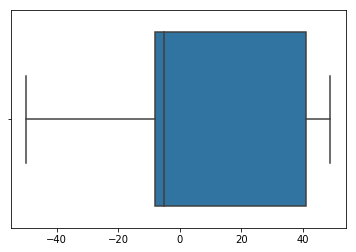

In [132]:
sns.boxplot(lags_trim)

In [135]:
np.mean(lags_trim)

6.133333333333334

In [128]:
np.std(lags_trim)

1.509043035951507

In [129]:
len(lags_trim)/len(lags)

0.4666666666666667

#### 1004 Sessions 0-5 results

In [638]:
np.mean(lags)

-1.9636363636363636

In [639]:
np.std(lags)

29.52531341461772

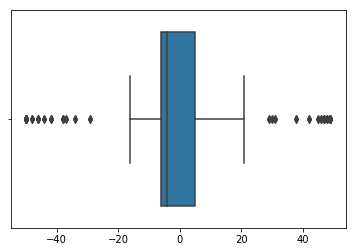

In [640]:
sns.boxplot(lags)

In [641]:
lags_temp = lags
IQR = np.percentile(lags_temp,75)-np.percentile(lags_temp,25)
lags_trim = [l for l in lags_temp if (l>np.percentile(lags_temp,25)-IQR*1.5)&(l<np.percentile(lags_temp,75)+IQR*1.5)]

while len(lags_trim)!=len(lags_temp):
    lags_temp = lags_trim
    IQR = np.percentile(lags_temp,75)-np.percentile(lags_temp,25)
    lags_trim = [l for l in lags_temp if (l>np.percentile(lags_temp,25)-IQR*1.5)&(l<np.percentile(lags_temp,75)+IQR*1.5)]

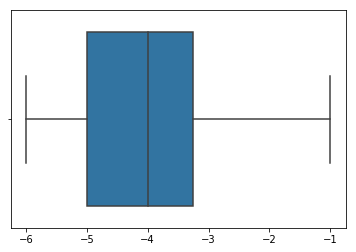

In [642]:
sns.boxplot(lags_trim)

In [643]:
np.mean(lags_trim)

-4.012820512820513

In [644]:
np.std(lags_trim)

1.1601678674247384

In [645]:
len(lags_trim)/len(lags)

0.4727272727272727

# Action list to correlate watch and sensor data
- offset = lag/50

# Load Data

## Load MC10 Sensor data

In [136]:
# Load Right hand accelerometer for subject 1004
MC10 = pd.read_csv(
    '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1016\\dorsal_hand_left\\d5la7y9p\\2017-07-13T13-59-14-600Z\\accel.csv')
MC10.loc[:,'Timestamp (ms)'] = MC10['Timestamp (ms)'].apply(
    lambda x: datetime.utcfromtimestamp(x/1000))

In [137]:
MC10['Mag'] = MC10.apply(lambda x: x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2,axis=1)

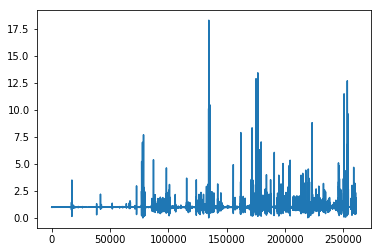

In [138]:
MC10['Mag'].plot()

## Load Watch data

In [174]:
watchfile = '//FS2.smpp.local\\RTO\\CIS-PD Study\\MJFF Curation\\TaskAcc\\1016_0_Wlkg.csv'

In [175]:
offset = 5

In [176]:
# 1004, trial 1, walking
Watch = pd.read_csv(watchfile)
# convert timestamp to datetime type
Watch['timestamp'] = pd.to_datetime(Watch['timestamp'])

# start = Watch.timestamp.min() - timedelta(seconds=offset/2)
# stop = Watch.timestamp.max() + timedelta(seconds=offset/2)

# Watch = pd.read_csv(orig_file)
# Watch['timestamp'] = pd.to_datetime(Watch['timestamp'])
# Watch = Watch[(Watch.timestamp>start) & (Watch.timestamp<stop)].copy()
# Watch.drop(columns='Unnamed: 0', inplace=True)

In [177]:
Watch['Mag'] = Watch.apply(lambda x: x['x']**2+x['y']**2+x['z']**2,axis=1)

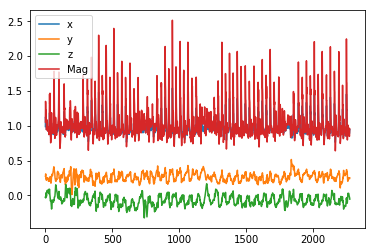

In [178]:
Watch.iloc[:,4:].plot()

## Find matching(?) time range

Done: 
- resample MC10 to match watch frequency (50Hz)
- add buffer (+/- 2s)
- find optimal lag from cross correlation

In [179]:
start = Watch.timestamp.min() - timedelta(seconds=offset)
stop = Watch.timestamp.max() + timedelta(seconds=offset)
inds = (MC10['Timestamp (ms)'] > start) & \
       (MC10['Timestamp (ms)'] < stop)

In [180]:
sum(inds)

3486

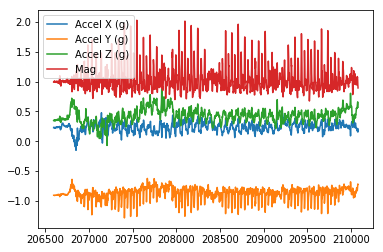

In [181]:
# plot after 2 sec offset
MC10[inds].iloc[:,1:].plot()

# Cross correlation between watch and MC10 sensors

In [182]:
# Walking
MC10Axis = 'Mag'; WatchAxis = 'Mag'
# # Nuts and Bolts
# MC10Axis = 'Accel Z (g)'; WatchAxis = 'z'
# # FtN
# MC10Axis = 'Accel Z (g)'; WatchAxis = 'x'

In [183]:
# 
A = resample(MC10.loc[inds,MC10Axis],len(Watch)+offset*100)
B = Watch[WatchAxis].values

In [184]:
A = (A/np.mean(A[offset*50:-offset*50]))#/np.std(A[100:-100])
B = (B/np.mean(B))#/np.std(B)

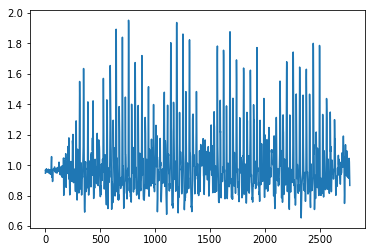

In [185]:
plt.plot(A)

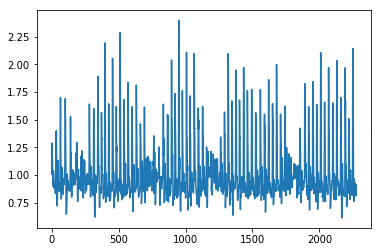

In [186]:
plt.plot(B)

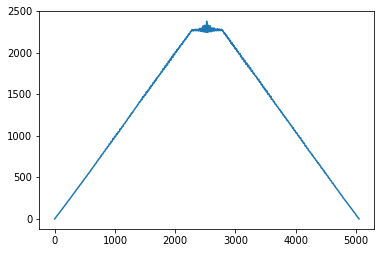

In [187]:
plt.plot(correlate(A,B))

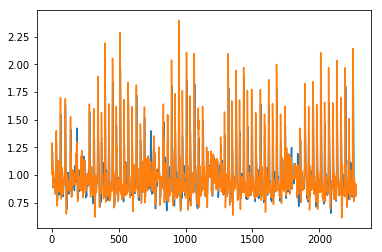

In [188]:
s1, s2 = 0, len(B)
A1 = A[246:]
plt.plot(A1[s1:s2])
B1 = B[s1:s2]
plt.plot(B1)

In [189]:
# use resampled MC10 y-axis to cross correlate against watch x-axis
lag = np.argmax(correlate(A, B))

In [190]:
# Walking
lag-len(B)-offset*50

-4

In [388]:
# FtnR
lag-len(B)-offset*50

-91

In [538]:
# Drinking
lag-len(B)-offset*50

506

In [541]:
lag

2094

In [540]:
len(A)

2088

In [539]:
len(B)

1088

In [600]:
MC10 = pd.read_csv(
    '//FS2.smpp.local\\RTO\\CIS-PD Study\\Subjects\\1004\\dorsal_hand_right\\d5la7ybu\\2017-07-07T13-15-16-759Z\\accel.csv')
MC10.loc[:,'Timestamp (ms)'] = MC10['Timestamp (ms)'].apply(
    lambda x: datetime.utcfromtimestamp(x/1000))

MC10['Mag'] = MC10.apply(lambda x: x['Accel X (g)']**2+x['Accel Y (g)']**2+x['Accel Z (g)']**2,axis=1)

In [218]:
lag

1728

In [219]:
offset = lag/50

In [220]:
offset

34.56

In [1]:
A = resample(sensor['Accel Y (g)'], len(Watch)+200)
B = Watch['x']

NameError: name 'resample' is not defined

In [223]:
len(Watch)

1728

In [50]:
len(A)

1928

In [287]:
A = sensor['Accel Y (g)']
B = Watch['x']
lag = np.argmax(correlate(A, B))
offset = lag/50

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [288]:
print(lag, offset)

1822 36.44


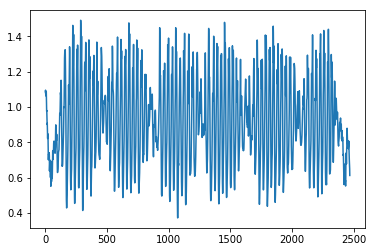

In [234]:
sensor['Accel Y (g)'].plot()

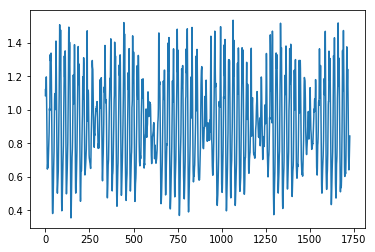

In [235]:
Watch['x'].plot()

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


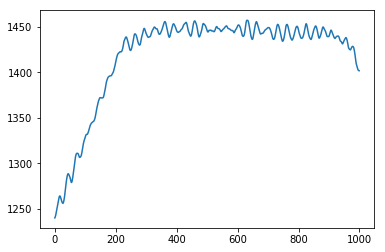

In [246]:

matplotlib.pyplot.plot(correlate(A, B))

In [244]:
len(correlate(A, B))

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


4197

In [245]:
len(A) + len(B)

4198

In [247]:
corr = correlate(A, B)

C:\Users\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [255]:
corr[0]

0.9151182126190246

In [254]:
A.values[0]*B.values[-1]

0.9151182126192108

In [260]:
(lag-len(B)+1)/50 - 2

6.08

In [289]:
lag-len(B)

94

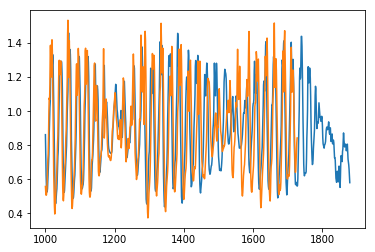

In [296]:
A1 = A.copy()

A1.index = A.index-(lag-len(B))

ax = A1.loc[1000:].plot()
B.loc[1000:].plot(ax = ax)

In [299]:
# Calculate time (in sec) that MC10 is behind the Watch
(lag-len(B))/50 - 2

-0.1200000000000001